Librerias necesarias:


In [ ]:
# Librerias a usar
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos de ML a usar
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Otros
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Configurar visualización y desactivar warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Recolección de la data


In [ ]:
# Lectura del dataset
df = pd.read_csv("raw_dataset.csv")
df.head()

## 2. Preparación / preprocesamiento de la data


##### a. Eliminación de características redundantes o innecesarias


In [ ]:
# Remover duplicados
df.drop_duplicates(inplace=True)

##### b. Limpieza de filas nulas, vacías o con error


In [ ]:
# Reemplazar valores nulos con pd.NA para luego borrarlos:

df.replace(["", " ", "?", "None", "N/A", "na"], pd.NA, inplace=True)

df_cleaned = df.dropna()
df_cleaned.reset_index(drop=True, inplace=True)

##### c. Encoder o codificador a las características no numéricas


In [ ]:
# Codificación de valores categóricos en valores númericos:

label_encoder = LabelEncoder()

df["smoker"].replace({"yes": 1, "no": 0}, inplace=True)
df["sex"].replace({"male": 1, "female": 0}, inplace=True)
df["region"] = label_encoder.fit_transform(df["region"])

##### d. Normalizar y estandarizar la data con un escalador de datos


In [ ]:
# Seleccionar columnas númericas
num_data = df.select_dtypes(include="number")

scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_data)
df_scaled = pd.DataFrame(scaled_data, columns=num_data.columns)

# Obtener el nuevo dataset escalado
df = df_scaled

## 3. Análisis descriptivo de la data (EDA)


##### a. Analisis de la data con gráficas


In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x=df["age"], kde=True, color="skyblue")
plt.title("Distribución de la edad de los contratistas", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
f = plt.figure(figsize=(12, 6))

ax = f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"], color="b", ax=ax)
ax.set_title("Distribución de cargos para fumadores")

ax = f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]["charges"], color="r", ax=ax)
ax.set_title("Distribución de cargos para fumadores")
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df["age"], y=df["children"], color="skyblue")
plt.title("Distribución de la edad de los contratistas.", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

##### b. Interpretación las estadísticas de los datos


In [ ]:
data = df
plt.figure(figsize=(6, 6))
sns.catplot(x="smoker", kind="count", hue="sex", palette="pink", data=data)
plt.show()

In [ ]:
sns.violinplot(
    data=data[data["sex"] == 1], x=data["smoker"], y="charges", palette="magma"
)

##### c. Interpretación de patrones de los datos con consultas y métodos de visualización.


In [ ]:
df["charges"] = df["charges"].round()
df.groupby([df["sex"], df["smoker"], df["region"]])["charges"].sum().reset_index()

In [ ]:
df[df["age"] < 25]

In [ ]:
sns.lineplot(
    data=df[((df["age"] < 25) & (df["smoker"] == 1) & (df["sex"] == 0))],
    x="age",
    y="charges",
)
sns.lineplot(
    data=df[((df["age"] < 25) & (df["smoker"] == 0) & (df["sex"] == 0))],
    x="age",
    y="charges",
)

In [ ]:
sns.jointplot(data[data["smoker"] == 1], x="age", y="charges", color="m")
sns.scatterplot(data[data["smoker"] == 1], x="age", y="charges", color="r")
sns.scatterplot(data[data["smoker"] == 0], x="age", y="charges", color="b")
plt.show()

In [ ]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette="inferno_r")
ax.set_title("Smokers and non-smokers")
plt.show()

In [ ]:
sns.boxplot(data=data, x=data["region"], y=data["charges"])
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color="c")

In [ ]:
sns.scatterplot(data, x="bmi", y="charges", color="c", hue="smoker")

In [ ]:
f = plt.figure(figsize=(12, 6))

ax = f.add_subplot(121)
sns.distplot(df[(df.bmi >= 3)]["charges"], color="b", ax=ax)
ax.set_title("Distribution of charges for Bmi >= 30")

ax = f.add_subplot(122)
sns.distplot(df[(df.bmi <= 30)]["charges"], color="c", ax=ax)
ax.set_title("Distribution of charges for Bmi >= 30")
plt.show()

In [ ]:
sns.catplot(
    x="smoker",
    kind="count",
    palette="rainbow",
    hue="sex",
    data=data[(data.children > 0)],
)
ax.set_title("Smokers and non-smokers who have childrens")

In [ ]:
sns.histplot(df[(df.children >= 3)]["charges"], color="b", kde=True)

In [ ]:
sns.histplot(df[(df.children < 3)]["charges"], color="c", kde=True)

## 4. Entrenamiento del modelo


Setup inicial:

In [ ]:
# Variables de entrada (X) y de salida (y)
X = df.drop("charges", axis=1)
y = df["charges"]

# Dividir en conjunto de entrenamiento y prueba: (80% entrenamiento y 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### - Ordinary Least Squares Regression


In [ ]:
def run_ols(X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo de regresión lineal (OLS).

    Este método estima los coeficientes de manera que se minimice
    la suma de los errores cuadráticos (mínimos cuadrados).

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global ols_model

    ols_model = LinearRegression()
    ols_model.fit(X_train, y_train)
    y_test_pred = ols_model.predict(X_test)

    metrics = {
        "R2": ols_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("Ordinary Least Squares Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


ols_metrics = run_ols(X_train, y_train, X_test, y_test)

Descripción:
- Este modelo es la regresión lineal clásica que estima los coeficientes minimizando la suma de los errores cuadráticos.

Comentarios:
- Es el modelo base y sirve como referencia para comparar el desempeño de modelos más complejos.

##### - Ridge Regression


In [ ]:
def run_ridge(X_train, y_train, X_test, y_test, alpha=1.0):
    """
    Entrena y evalúa un modelo de Ridge Regression.

    Ridge agrega un término de penalización (L2) al proceso de
    minimización de errores, ayudando a evitar el sobreajuste.

    Parámetros:
        alpha (float): Hiperparámetro que controla la regularización.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global ridge_model

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_test_pred = ridge_model.predict(X_test)

    metrics = {
        "R2": ridge_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("Ridge Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


ridge_metrics = run_ridge(X_train, y_train, X_test, y_test, alpha=1.0)

Descripción:
- Ridge agrega un término de penalización (L2) a la función de pérdida, lo que ayuda a reducir el sobreajuste y manejar la multicolinealidad.

Hiperparámetros clave:
- alpha: Controla la intensidad de la regularización.

##### - Bayesian Regression


In [ ]:
def run_bayesian(X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo de Bayesian Ridge Regression.

    Este modelo aplica un enfoque bayesiano para estimar los parámetros,
    lo que permite incorporar la incertidumbre de las estimaciones.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global bayesian_model

    bayesian_model = BayesianRidge()
    bayesian_model.fit(X_train, y_train)
    y_test_pred = bayesian_model.predict(X_test)

    metrics = {
        "R2": bayesian_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),  # type: ignore
    }

    print("Bayesian Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


bayesian_metrics = run_bayesian(X_train, y_train, X_test, y_test)

Descripción:
- Utiliza un enfoque bayesiano para estimar los parámetros del modelo, incorporando la incertidumbre inherente en las estimaciones y permitiendo una interpretación probabilística.

Comentarios:
- Es especialmente útil cuando se requiere una medida de la incertidumbre.

##### - Lasso Regression


In [ ]:
def run_lasso(X_train, y_train, X_test, y_test, alpha=0.1):
    """
    Entrena y evalúa un modelo de Lasso Regression.

    Lasso utiliza una penalización L1, lo que puede hacer que algunos
    coeficientes se vuelvan exactamente cero, realizando una selección de características.

    Parámetros:
        alpha (float): Hiperparámetro que controla la intensidad de la regularización.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global lasso_model

    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    y_test_pred = lasso_model.predict(X_test)

    metrics = {
        "R2": lasso_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("Lasso Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


lasso_metrics = run_lasso(X_train, y_train, X_test, y_test, alpha=0.1)

Descripción:
- Emplea una penalización L1 que puede reducir algunos coeficientes a cero, realizando así una selección de características de manera implícita.

Hiperparámetros clave:
- alpha: Controla la intensidad de la penalización.

##### - Nearest Neighbors Regression


In [ ]:
def run_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    """
    Entrena y evalúa un modelo de K-Nearest Neighbors Regression.

    El modelo predice el valor de la etiqueta basándose en el promedio de los
    K vecinos más cercanos en el espacio de características.

    Parámetros:
        n_neighbors (int): Número de vecinos a considerar.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global knn_model

    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    y_test_pred = knn_model.predict(X_test)

    metrics = {
        "R2": knn_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("Nearest Neighbors Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


knn_metrics = run_knn(X_train, y_train, X_test, y_test, n_neighbors=5)

Descripción:
- Predice la etiqueta de una instancia basándose en el promedio de los K vecinos más cercanos en el espacio de características.

Hiperparámetros clave:
- n_neighbors: Número de vecinos considerados en la predicción.

##### - Random Forest Regression


In [ ]:
def run_random_forest(X_train, y_train, X_test, y_test, n_estimators=100):
    """
    Entrena y evalúa un modelo de Random Forest Regression.

    Random Forest es un conjunto (ensemble) de árboles de decisión que
    mejora la precisión y controla el sobreajuste mediante la agregación de múltiples predicciones.

    Parámetros:
        n_estimators (int): Número de árboles en el bosque.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global rf_model

    rf_model = RandomForestRegressor(
        n_estimators=n_estimators, random_state=1, n_jobs=-1
    )

    rf_model.fit(X_train, y_train)
    y_test_pred = rf_model.predict(X_test)

    metrics = {
        "R2": rf_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("Random Forest Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


rf_metrics = run_random_forest(X_train, y_train, X_test, y_test, n_estimators=100)

Descripción:
- Es un método ensemble que utiliza múltiples árboles de decisión para mejorar la robustez y la precisión del modelo mediante la agregación de predicciones.

Hiperparámetros clave:
- n_estimators: Número de árboles en el bosque.

##### - SVM (Support Vector Machine) Regression


In [ ]:
def run_svr(X_train, y_train, X_test, y_test, kernel="rbf", C=1.0, epsilon=0.2):
    """
    Entrena y evalúa un modelo de SVM Regression.

    El modelo SVR (Support Vector Regression) intenta encontrar una función
    que tenga a lo sumo una desviación epsilon de las observaciones reales,
    usando núcleos para capturar relaciones no lineales.

    Parámetros:
        kernel (str): Tipo de kernel a utilizar.
        C (float): Parámetro de regularización.
        epsilon (float): Margen dentro del cual no se penalizan errores.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global svr_model

    svr_model = SVR(kernel=kernel, C=C, epsilon=epsilon) # type: ignore
    svr_model.fit(X_train, y_train)
    y_test_pred = svr_model.predict(X_test)

    metrics = {
        "R2": svr_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }

    print("SVM Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


svr_metrics = run_svr(
    X_train, y_train, X_test, y_test, kernel="rbf", C=1.0, epsilon=0.2
)

Descripción:
- Busca encontrar una función que tenga a lo sumo una desviación epsilon de los valores reales, utilizando núcleos (kernel) para capturar relaciones no lineales.

Hiperparámetros clave:
- kernel: Tipo de función kernel (por ejemplo, "rbf").
- C: Parámetro de regularización.
- epsilon: Tolerancia para los errores.

##### - Neural Network MLP Regression


In [ ]:
def run_mlp(X_train, y_train, X_test, y_test, hidden_layer_sizes=(100,), max_iter=500):
    """
    Entrena y evalúa un modelo de MLP Regressor.

    Se utiliza una red neuronal (MLP) para modelar relaciones complejas.
    El hiperparámetro 'hidden_layer_sizes' define la arquitectura de la red.

    Parámetros:
        hidden_layer_sizes (tuple): Número de neuronas en cada capa oculta.
        max_iter (int): Número máximo de iteraciones para el entrenamiento.

    Retorna:
        dict: Diccionario con las métricas 'R2' y 'MSE' sobre el conjunto de prueba.
    """

    global mlp_model

    mlp_model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=1
    )

    mlp_model.fit(X_train, y_train)
    y_test_pred = mlp_model.predict(X_test)

    metrics = {
        "R2": mlp_model.score(X_test, y_test),
        "MSE": mean_squared_error(y_test, y_test_pred),
    }
    
    print("Neural Network MLP Regression:")
    print("  R² Score:", metrics["R2"])
    print("  MSE:", metrics["MSE"])
    return metrics


mlp_metrics = run_mlp(
    X_train, y_train, X_test, y_test, hidden_layer_sizes=(100,), max_iter=500
)

Descripción:
- Utiliza una red neuronal de perceptrones multicapa (MLP) para modelar relaciones complejas entre las variables.

Hiperparámetros clave:
- hidden_layer_sizes: Define la arquitectura de la red (número de neuronas en cada capa oculta).
- max_iter: Número máximo de iteraciones para el entrenamiento.

## 5. Validación y testeo del modelo


En esta sección se evalúa la capacidad de generalización del modelo, asegurando la robustez del modelo.

Se ha dividido el conjunto de datos en un 80% para entrenamiento y un 20% para prueba. Además, se ha implementado una validación cruzada k-fold (k=5) para estimar la estabilidad del desempeño del modelo.

#### *Comparación de Modelos y Pruebas de Robustez


In [ ]:
# Resultados de cada modelo
results = {
    "Ordinary Least Squares": ols_metrics,
    "Ridge Regression": ridge_metrics,
    "Bayesian Regression": bayesian_metrics,
    "Lasso Regression": lasso_metrics,
    "Nearest Neighbors Regression": knn_metrics,
    "Random Forest Regression": rf_metrics,
    "SVM Regression": svr_metrics,
    "Neural Network MLP Regression": mlp_metrics
}

# Convertir los resultados en un DataFrame para una mejor visualización
results_df = pd.DataFrame(results).T  # Transponer para que cada fila sea un modelo
results_df = results_df.rename(columns={"R2": "R² Score", "MSE": "MSE"})
results_df

#### *Validación Cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

# Validación del modelo de LinearRegression:
scores = cross_val_score(ols_model, X, y, cv=5, scoring='r2')
print("R² en validación cruzada: %.2f ± %.2f" % (scores.mean(), scores.std()))

#### *Análisis de Residuales

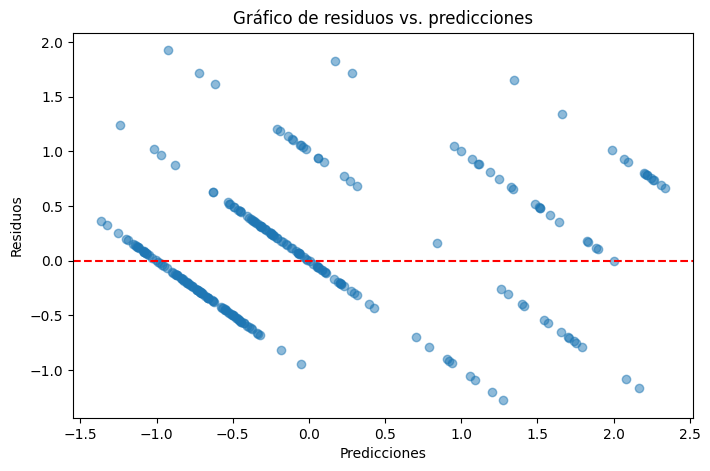

In [45]:
y_pred_test = ols_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos vs. predicciones")
plt.show()

## 6. Despliegue del modelo y comprobación con data recién creada


Función para desplegar el modelo.

In [ ]:
def desplegar_modelo(model, new_data_path:str):
    """
    Carga un nuevo archivo CSV, lo preprocesa de forma similar
    al dataset de entrenamiento y realiza predicciones con el modelo dado.

    Parámetros:
        model: Modelo entrenado (por ejemplo, el mejor modelo seleccionado).
        new_data_path (str): Ruta al archivo CSV con datos nuevos.

    Retorna:
        np.array: Predicciones realizadas por el modelo.
    """

    # Lectura del nuevo dataset
    new_df = pd.read_csv(new_data_path)

    # - Preprocesamiento:

    new_df.drop_duplicates(inplace=True)
    new_df.replace(["", " ", "?", "None", "N/A", "na"], pd.NA, inplace=True)
    new_df_cleaned = new_df.dropna()
    new_df_cleaned.reset_index(drop=True, inplace=True)

    # Codificar variables categóricas
    new_df["smoker"].replace({"yes": 1, "no": 0}, inplace=True)
    new_df["sex"].replace({"male": 1, "female": 0}, inplace=True)
    new_df["region"] = label_encoder.fit_transform(new_df["region"])

    # Estandarizar utilizando el mismo escalador
    new_num_data = new_df.select_dtypes(include="number")
    new_scaled_data = scaler.fit_transform(new_num_data)
    new_df_scaled = pd.DataFrame(new_scaled_data, columns=new_num_data.columns)
    new_df = new_df_scaled

    # Separar las entradas
    X_new = new_df.drop("charges", axis=1)

    # Realizar predicciones
    predictions = model.predict(X_new)
    return predictions

Ejemplo de uso.

In [ ]:
# Elegir el mejor modelo y la ruta al nuevo dataset
mejor_modelo = rf_model
nuevo_dataset = "ruta_al_nuevo_dataset.csv"

# Obtener nuevas predicciones
predicciones = desplegar_modelo(mejor_modelo, nuevo_dataset)
print(predicciones)